In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv
/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv


**Objective -->To identify countries those are in need of financial assistance.**

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
desc = pd.read_csv('/kaggle/input/unsupervised-learning-on-country-data/data-dictionary.csv')

In [4]:
desc

Column Name  \
0     country   
1  child_mort   
2     exports   
3      health   
4     imports   
5      Income   
6   Inflation   
7  life_expec   
8   total_fer   
9        gdpp   

                                                                                                        Description  
0                                                                                               Name of the country  
1                                                       Death of children under 5 years of age per 1000 live births  
2                                     Exports of goods and services per capita. Given as %age of the GDP per capita  
3                                                 Total health spending per capita. Given as %age of GDP per capita  
4                                     Imports of goods and services per capita. Given as %age of the GDP per capita  
5                                                                                             Net income per person  
6                                                        The measurement of the annual growth rate of the Total GDP  
7  The average number of years a new born child would live if the current mortality patterns are to remain the same  
8       The number of children that would be born to each woman if the current age-fertility rates remain the same.  
9                                  The GDP per capita. Calculated as the Total GDP divided by the total population.

In [5]:
df = pd.read_csv('/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv')
df.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

In [6]:
#exports,health,imports are given in percentage of GDPP..
#converting to its actual value

df[['exports', 'health', 'imports']] = (df[['exports', 'health', 'imports']]).multiply(df["gdpp"]/100, axis="index")

In [7]:
df.head()

country  child_mort  exports    health   imports  income  \
0          Afghanistan        90.2    55.30   41.9174   248.297    1610   
1              Albania        16.6  1145.20  267.8950  1987.740    9930   
2              Algeria        27.3  1712.64  185.9820  1400.440   12900   
3               Angola       119.0  2199.19  100.6050  1514.370    5900   
4  Antigua and Barbuda        10.3  5551.00  735.6600  7185.800   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


<Axes: >

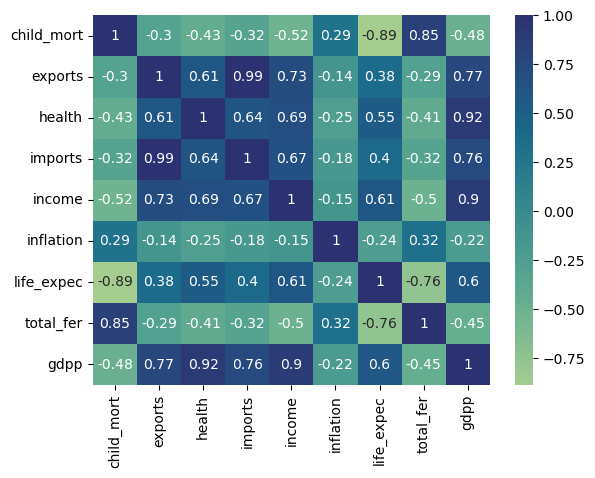

In [9]:
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='crest')

In [10]:
df.describe(percentiles=[.25,.50,.75,.90,.95])

child_mort        exports       health        imports         income  \
count  167.000000     167.000000   167.000000     167.000000     167.000000   
mean    38.270060    7420.618847  1056.733204    6588.352108   17144.688623   
std     40.328931   17973.885795  1801.408906   14710.810418   19278.067698   
min      2.600000       1.076920    12.821200       0.651092     609.000000   
25%      8.250000     447.140000    78.535500     640.215000    3355.000000   
50%     19.300000    1777.440000   321.886000    2045.580000    9960.000000   
75%     62.100000    7278.000000   976.940000    7719.600000   22800.000000   
90%    100.220000   17760.600000  3825.416000   15034.280000   41220.000000   
95%    116.000000   31385.100000  4966.701000   24241.560000   48290.000000   
max    208.000000  183750.000000  8663.600000  149100.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000  
50%      5.390000   73.100000    2.410000    4660.000000  
75%     10.750000   76.800000    3.880000   14050.000000  
90%     16.640000   80.400000    5.322000   41840.000000  
95%     20.870000   81.400000    5.861000   48610.000000  
max    104.000000   82.800000    7.490000  105000.000000

In [11]:
from pandas_profiling import ProfileReport

In [12]:
df.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

EDA

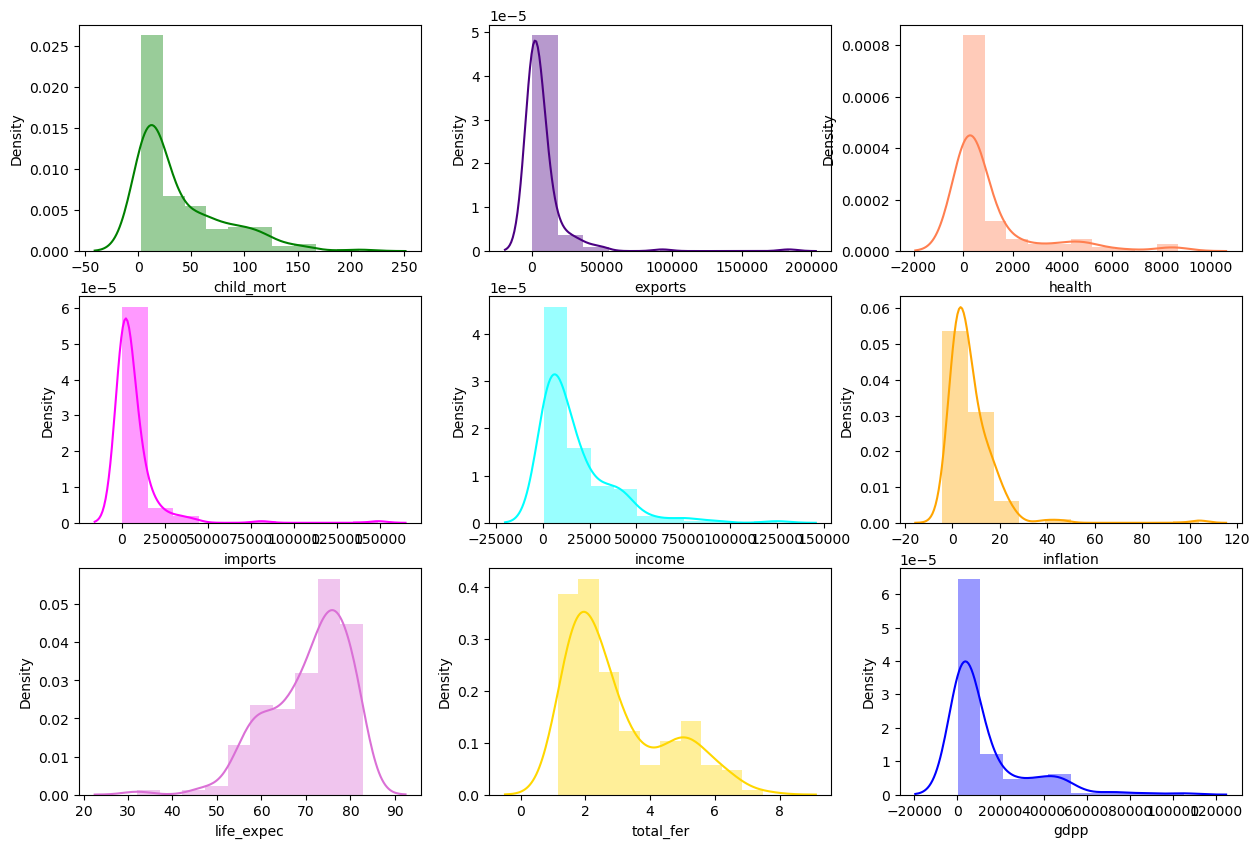

In [13]:
f, ax = plt.subplots(3,3,figsize=(15,10))
a1 = sns.distplot(df["child_mort"], bins=10, ax=ax[0][0],color='green')
a2 = sns.distplot(df["exports"],bins=10, ax=ax[0][1],color='indigo')
a3 = sns.distplot(df["health"],bins=10, ax=ax[0][2],color="coral")
a4 = sns.distplot(df["imports"],bins=10, ax=ax[1][0],color="fuchsia")
a5 = sns.distplot(df["income"],bins=10, ax=ax[1][1],color="cyan")
a6 = sns.distplot(df["inflation"],bins=10, ax=ax[1][2],color="orange")
a7 = sns.distplot(df["life_expec"],bins=10, ax=ax[2][0],color="orchid")
a8 = sns.distplot(df["total_fer"],bins=10, ax=ax[2][1],color="gold")
a9 = sns.distplot(df["gdpp"],bins=10, ax=ax[2][2],color="blue")

* It looks like all the features are right skewed except life expect, so it means data have so many outliers.
* So lets plot the Box plot

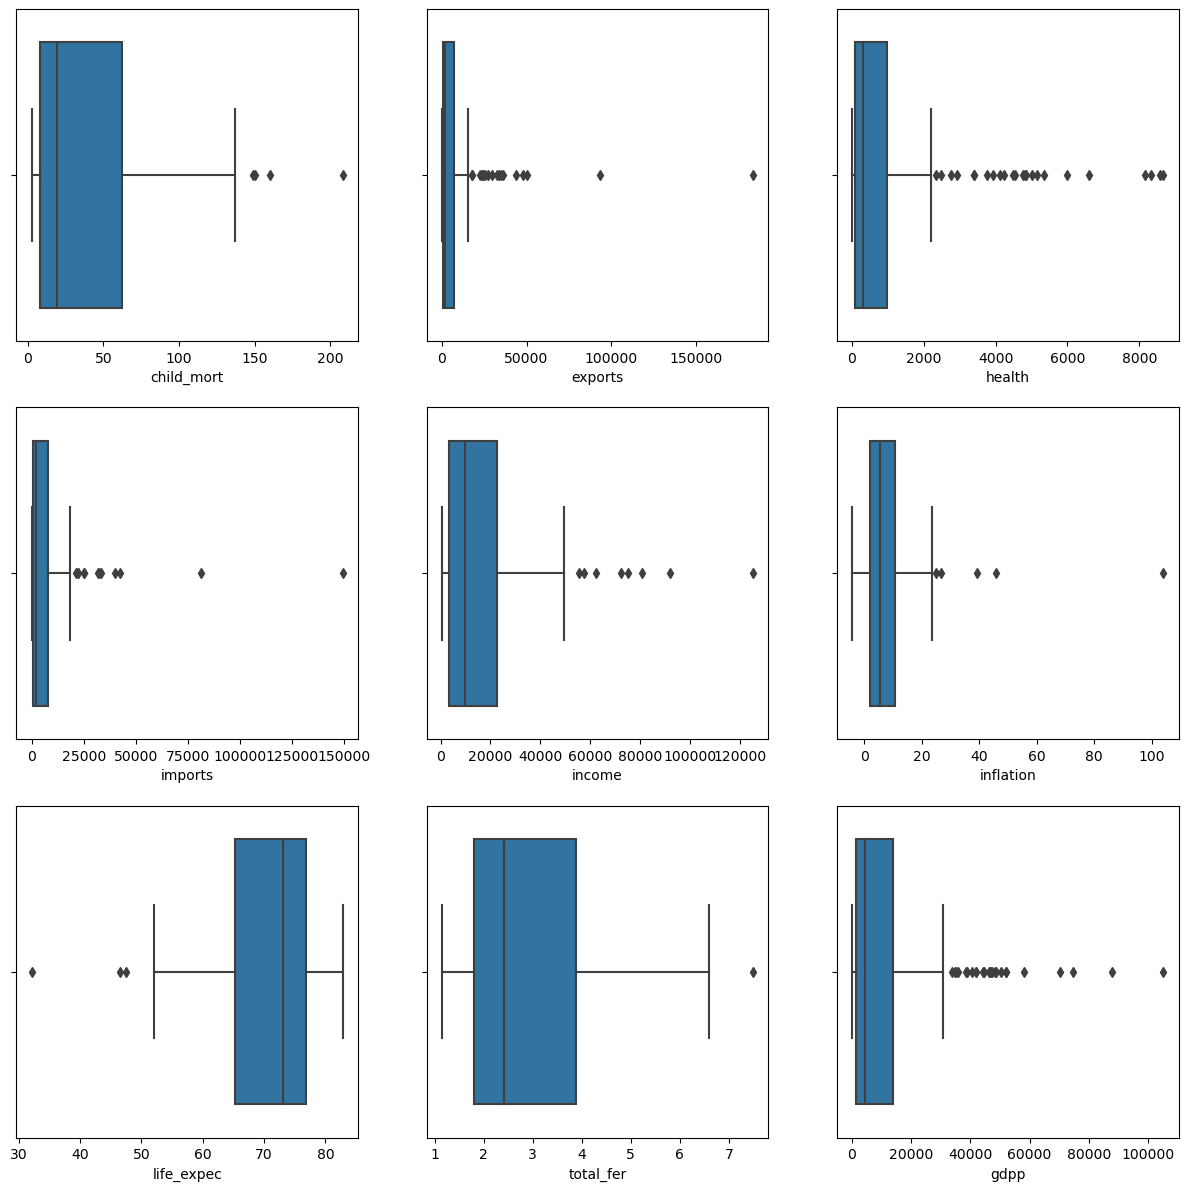

In [14]:
fig = plt.figure(figsize=(15,25))
for i, feature in enumerate(df.columns[1:]):
    fig.add_subplot(5,3,i+1)
    sns.boxplot(x=df[feature], data=df)

* Most of the outliers are in exports,health and gdpp.
* There are only 167 rows, so removing these outliers will remove the crucial information from the datesets.
* GDPP is the GDP per capita i.e Calculated as the Total GDP divided by the total population, so the coutries with high gdpp would not require an aid thats why I will remove those from the dataset.
* But removing outliers from health,exports and others will impact the dataset.

In [15]:
df[df['gdpp']>df['gdpp'].quantile(.95)]

country  child_mort   exports   health   imports  income  inflation  \
7      Australia         4.8   10276.2  4530.87   10847.1   41400      1.160   
44       Denmark         4.1   29290.0  6612.00   25288.0   44000      3.220   
73       Ireland         4.2   50161.0  4475.53   42125.5   45700     -3.220   
91    Luxembourg         2.8  183750.0  8158.50  149100.0   91700      3.620   
110  Netherlands         4.5   36216.0  5985.70   31990.8   45500      0.848   
114       Norway         3.2   34856.6  8323.44   25023.0   62300      5.950   
123        Qatar         9.0   43796.9  1272.43   16731.4  125000      6.980   
144       Sweden         3.0   24070.2  5017.23   21204.7   42900      0.991   
145  Switzerland         4.5   47744.0  8579.00   39761.8   55500      0.317   

     life_expec  total_fer    gdpp  
7          82.0       1.93   51900  
44         79.5       1.87   58000  
73         80.4       2.05   48700  
91         81.3       1.63  105000  
110        80.7       1.79   50300  
114        81.0       1.95   87800  
123        79.5       2.07   70300  
144        81.5       1.98   52100  
145        82.2       1.52   74600

In [16]:
new_df = df[df['gdpp']<df['gdpp'].quantile(.95)]

In [17]:
new_df.shape

(158, 10)

**Distribution of Features across the Dataset with Kernel Density Estimation (KDE)**

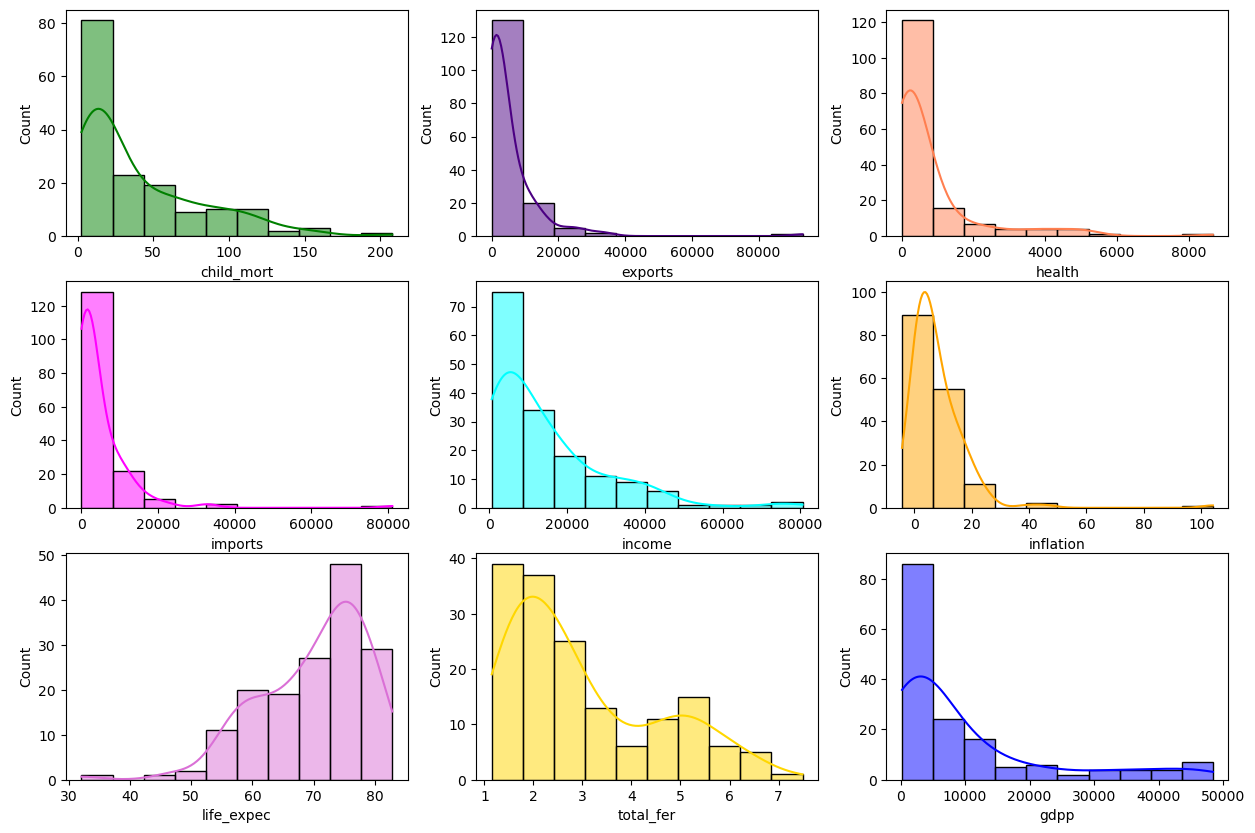

In [18]:
f, ax = plt.subplots(3,3,figsize=(15,10))
a1 = sns.histplot(new_df["child_mort"], bins=10, ax=ax[0][0],color='green',kde=True)
a2 = sns.histplot(new_df["exports"],bins=10, ax=ax[0][1],color='indigo',kde=True)
a3 = sns.histplot(new_df["health"],bins=10, ax=ax[0][2],color="coral",kde=True)
a4 = sns.histplot(new_df["imports"],bins=10, ax=ax[1][0],color="fuchsia",kde=True)
a5 = sns.histplot(new_df["income"],bins=10, ax=ax[1][1],color="cyan",kde=True)
a6 = sns.histplot(new_df["inflation"],bins=10, ax=ax[1][2],color="orange",kde=True)
a7 = sns.histplot(new_df["life_expec"],bins=10, ax=ax[2][0],color="orchid",kde=True)
a8 = sns.histplot(new_df["total_fer"],bins=10, ax=ax[2][1],color="gold",kde=True)
a9 = sns.histplot(new_df["gdpp"],bins=10, ax=ax[2][2],color="blue",kde=True)

**the countries with the highest and lowest values for each feature using barplot**

**1. For child_mort**

In [19]:
new_df_sort_CM = new_df.sort_values(by='child_mort', ascending=False)

In [20]:
new_df_sort_CM.head()

country  child_mort  exports   health  imports  income  \
66                      Haiti       208.0  101.286  45.7442  428.314    1500   
132              Sierra Leone       160.0   67.032  52.2690  137.655    1220   
32                       Chad       150.0  330.096  40.6341  390.195    1930   
31   Central African Republic       149.0   52.628  17.7508  118.190     888   
97                       Mali       137.0  161.424  35.2584  248.508    1870   

     inflation  life_expec  total_fer  gdpp  
66        5.45        32.1       3.33   662  
132      17.20        55.0       5.20   399  
32        6.39        56.5       6.59   897  
31        2.01        47.5       5.21   446  
97        4.37        59.5       6.55   708

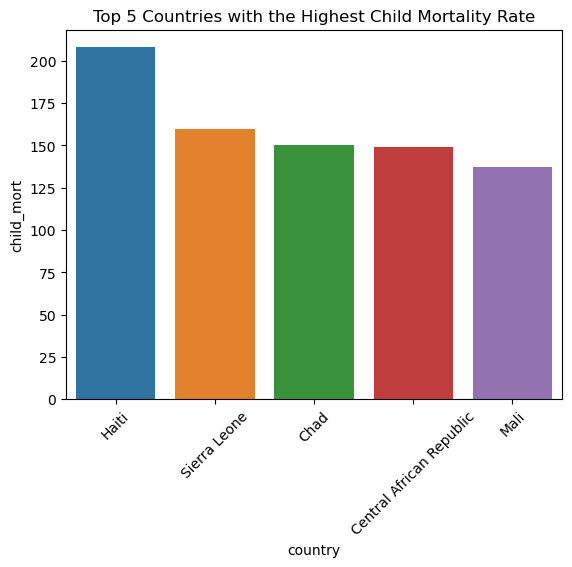

In [21]:
sns.barplot(new_df_sort_CM.iloc[:5],x='country',y='child_mort')
plt.title ('Top 5 Countries with the Highest Child Mortality Rate')
plt.xticks(rotation=45);

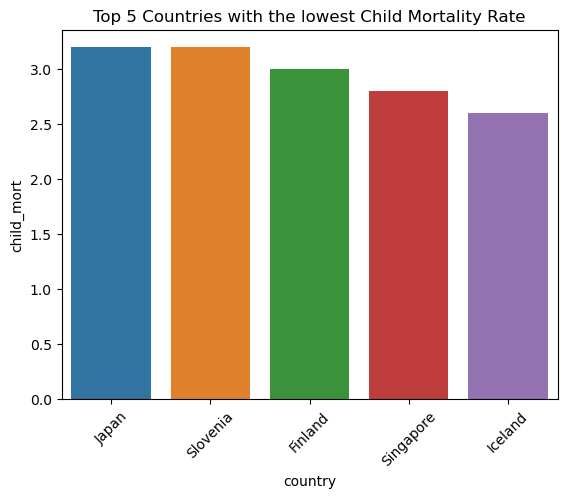

In [22]:
sns.barplot(new_df_sort_CM.iloc[-5:],x='country',y='child_mort')
plt.title ('Top 5 Countries with the lowest Child Mortality Rate')
plt.xticks(rotation=45);

**2. Exports**

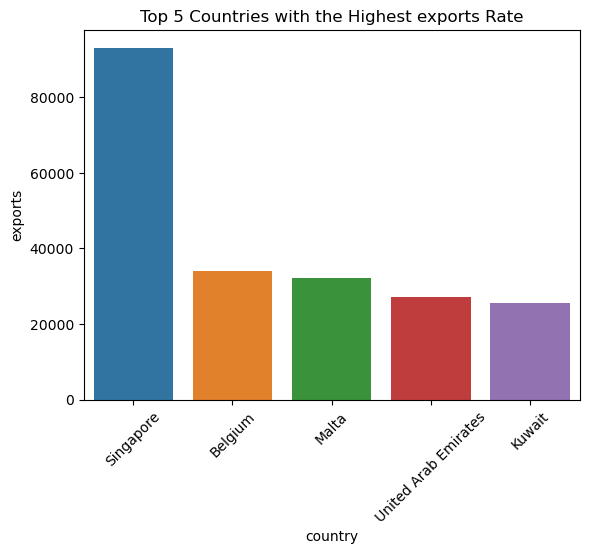

In [23]:
new_df_sort_expert = new_df.sort_values(by='exports', ascending=False)
sns.barplot(new_df_sort_expert.iloc[:5],x='country',y='exports')
plt.title ('Top 5 Countries with the Highest exports Rate')
plt.xticks(rotation=45);

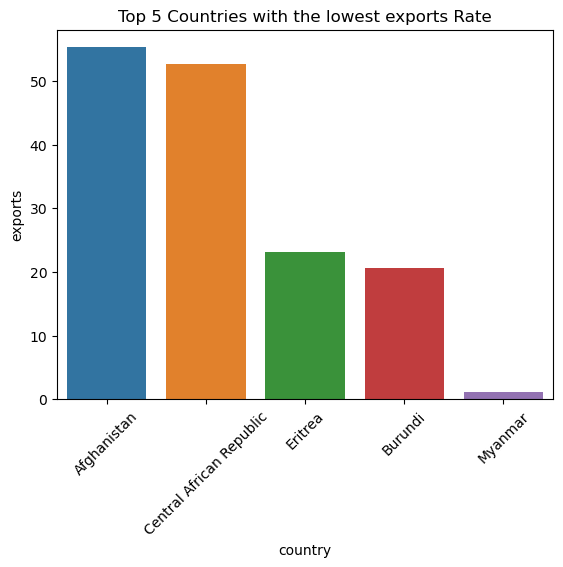

In [24]:
new_df_sort_expert = new_df.sort_values(by='exports', ascending=False)
sns.barplot(new_df_sort_expert.iloc[-5:],x='country',y='exports')
plt.title ('Top 5 Countries with the lowest exports Rate')
plt.xticks(rotation=45);

**3.Health**

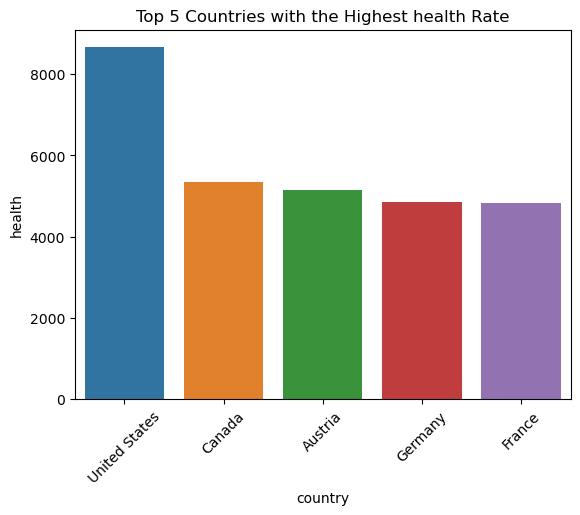

In [25]:
new_df_sort_health = new_df.sort_values(by='health', ascending=False)
sns.barplot(new_df_sort_health.iloc[:5],x='country',y='health')
plt.title ('Top 5 Countries with the Highest health Rate')
plt.xticks(rotation=45);

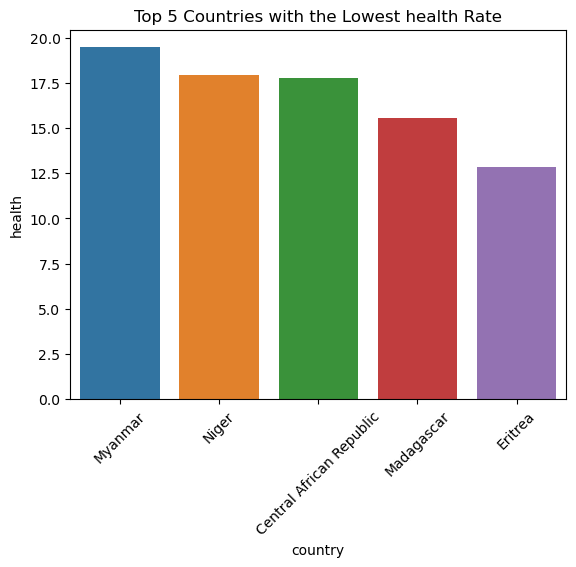

In [26]:
new_df_sort_health = new_df.sort_values(by='health', ascending=False)
sns.barplot(new_df_sort_health.iloc[-5:],x='country',y='health')
plt.title ('Top 5 Countries with the Lowest health Rate')
plt.xticks(rotation=45);

**Standardizing the data**

In [27]:
features = new_df.columns
standard_scaler = StandardScaler()
countries_scaled= standard_scaler.fit_transform(new_df.drop('country', axis=1))
countries_scaled

array([[ 1.2348468 , -0.51008966, -0.56360764, ..., -1.57290118,
         1.83898931, -0.73837646],
       [-0.58270965, -0.39606338, -0.39146172, ...,  0.7236459 ,
        -0.88967589, -0.45936668],
       [-0.3184725 , -0.33669732, -0.45386166, ...,  0.74649712,
        -0.07827425, -0.4301799 ],
       ...,
       [-0.41725274, -0.4171968 , -0.5272808 , ...,  0.35802647,
        -0.69336904, -0.6786619 ],
       [ 0.39768425, -0.4747592 , -0.54384653, ..., -0.28180754,
         1.08647972, -0.6786619 ],
       [ 1.05951187, -0.45935901, -0.53003083, ..., -2.05277669,
         1.56415972, -0.66682942]])

# Using Kmean Clustering approach

In [28]:
score=[]
for i in range(2,10):
    km = KMeans(n_clusters=i)
    km.fit(countries_scaled)
    score.append(km.inertia_)

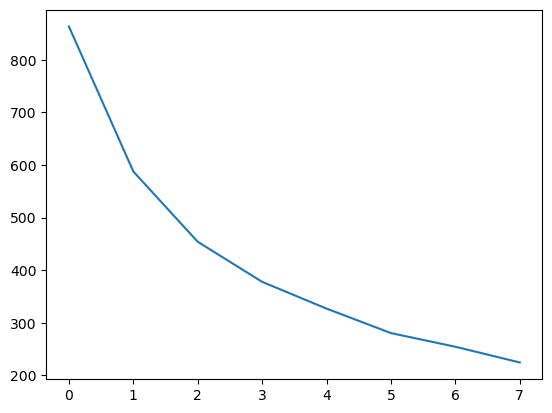

In [29]:
plt.plot(score,)

**Visualizing the optimal numbers of clusters**

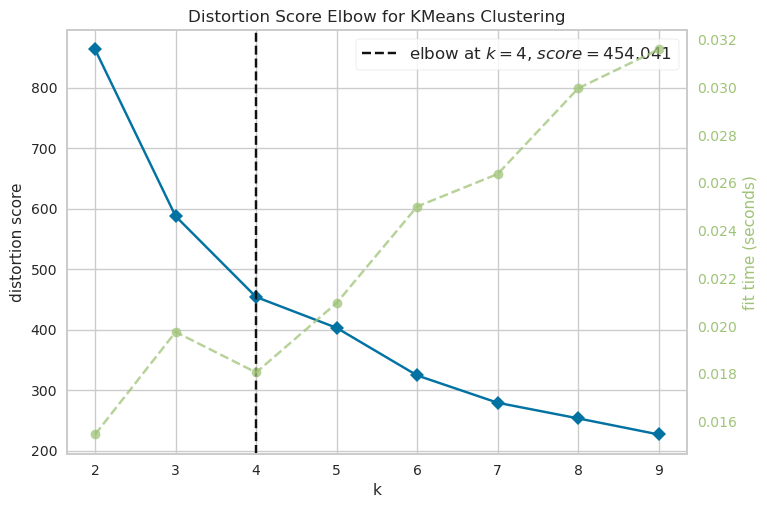

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(n_clusters=i)
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(countries_scaled)        # Fit data to visualizer
visualizer.show() 

*  The silhouette score falls within the range [-1, 1]
*  A high average silhouette width indicates a good clustering.
*  silhouette_score for k=3 to k=10

In [31]:
from sklearn.metrics import silhouette_score
for i in range(3,11):
    km = KMeans(n_clusters=i, random_state=4)
    km.fit_predict(countries_scaled)
    score = silhouette_score(countries_scaled, km.labels_, metric='euclidean')
    print('Silhouetter Average Score for {} clusters is {}:'.format(i,score))

Silhouetter Average Score for 3 clusters is 0.4149565322037642:
Silhouetter Average Score for 4 clusters is 0.4237047080729114:
Silhouetter Average Score for 5 clusters is 0.4269917078918058:
Silhouetter Average Score for 6 clusters is 0.3134093837899716:
Silhouetter Average Score for 7 clusters is 0.30386007119412284:
Silhouetter Average Score for 8 clusters is 0.2936591733739597:
Silhouetter Average Score for 9 clusters is 0.25832154677392427:
Silhouetter Average Score for 10 clusters is 0.30061086201074333:


Best silhouette_score has obtained from cluster number 5. so considering the optimal number of clusters as 5

In [32]:
km = KMeans(n_clusters=5)
y = km.fit_predict(countries_scaled)

In [33]:
countries_kmeans = new_df.copy()
countries_kmeans['Labels'] = y
countries_kmeans.head()

country  child_mort  exports    health   imports  income  \
0          Afghanistan        90.2    55.30   41.9174   248.297    1610   
1              Albania        16.6  1145.20  267.8950  1987.740    9930   
2              Algeria        27.3  1712.64  185.9820  1400.440   12900   
3               Angola       119.0  2199.19  100.6050  1514.370    5900   
4  Antigua and Barbuda        10.3  5551.00  735.6600  7185.800   19100   

   inflation  life_expec  total_fer   gdpp  Labels  
0       9.44        56.2       5.82    553       0  
1       4.49        76.3       1.65   4090       2  
2      16.10        76.5       2.89   4460       2  
3      22.40        60.1       6.16   3530       0  
4       1.44        76.8       2.13  12200       2

In [34]:
countries_kmeans['Labels'].value_counts()

2    80
0    47
1    29
4     1
3     1
Name: Labels, dtype: int64

[Text(0.5, 0, 'GDPP'), Text(0, 0.5, 'Child Mortality Rate')]

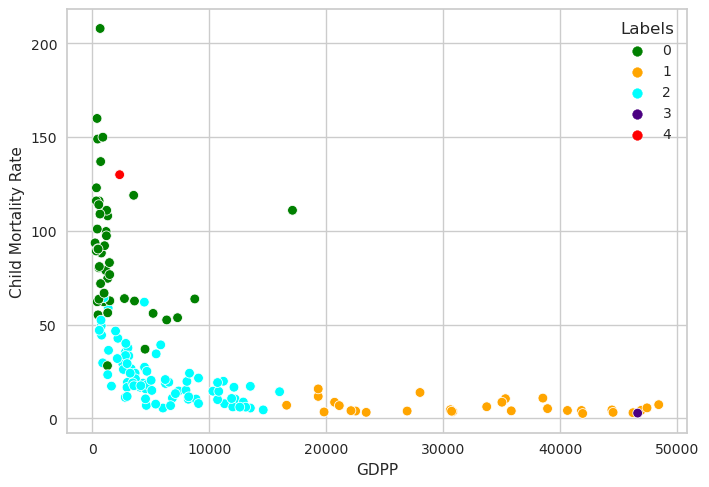

In [35]:
axes = sns.scatterplot(x='gdpp',y='child_mort',hue='Labels',legend='full',data=countries_kmeans, palette=['green','orange','cyan','indigo','red'])
axes.set(xlabel = 'GDPP', ylabel= 'Child Mortality Rate')

[Text(0.5, 0, 'health'), Text(0, 0.5, 'Child Mortality Rate')]

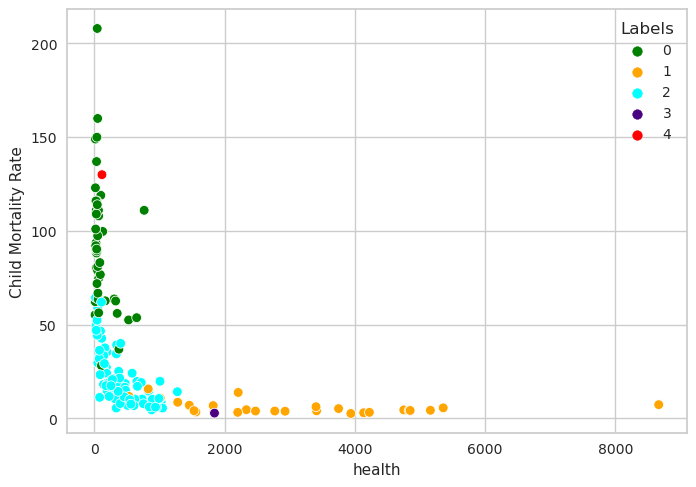

In [36]:
axes = sns.scatterplot(x='health',y='child_mort',hue='Labels',legend='full',data=countries_kmeans, palette=['green','orange','cyan','indigo','red'])
axes.set(xlabel = 'health', ylabel= 'Child Mortality Rate')

[Text(0.5, 0, 'life_expec'), Text(0, 0.5, 'Child Mortality Rate')]

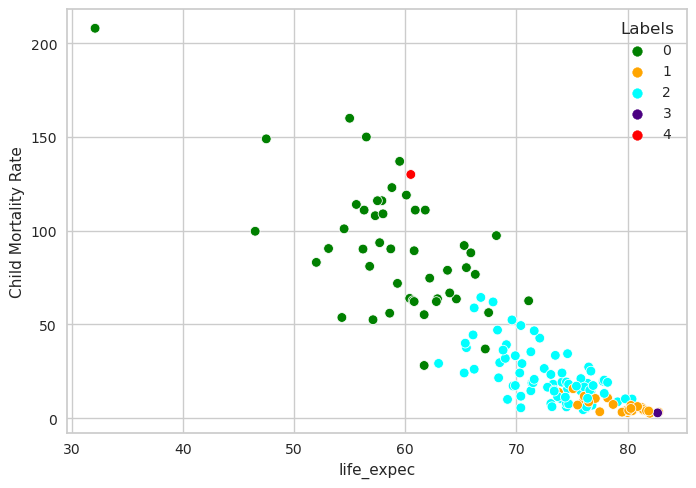

In [37]:
axes = sns.scatterplot(x='life_expec',y='child_mort',hue='Labels',legend='full',data=countries_kmeans, palette=['green','orange','cyan','indigo','red'])
axes.set(xlabel = 'life_expec', ylabel= 'Child Mortality Rate')

**Visualizing clusters using PCA**

In [38]:
distance = 1-cosine_similarity(countries_scaled)
pca = PCA(2)
pca_1_2 = pca.fit_transform(distance)

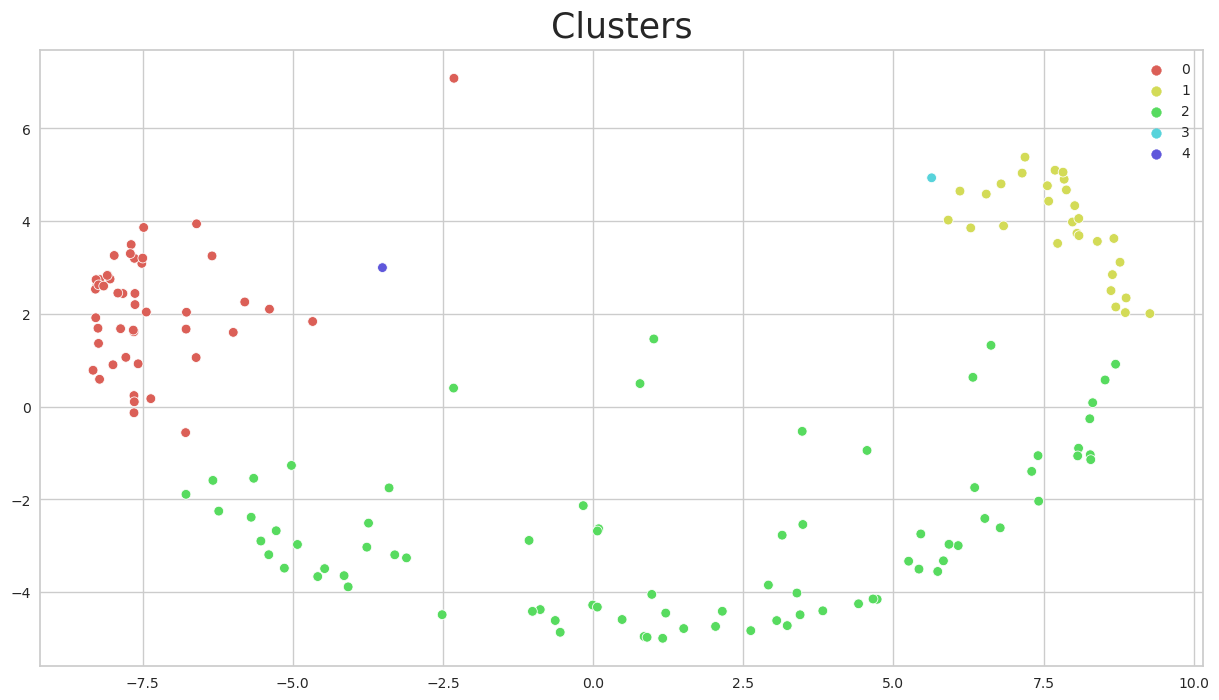

In [39]:
plt.figure(figsize=(15,8))
sns.scatterplot(x=pca_1_2[:, 0], y=pca_1_2[:, 1],hue=y,palette=sns.color_palette('hls'))
plt.title('Clusters', size=25, pad=10)
plt.legend(loc=0, bbox_to_anchor=[1,1])
plt.show()

In [40]:
no_of_clusters = countries_kmeans.groupby(by='Labels')
child_mort_mean = no_of_clusters['child_mort'].mean()
exports_mean = no_of_clusters['exports'].mean()
health_mean = no_of_clusters['health'].mean()
imports_mean = no_of_clusters['imports'].mean()
income_mean = no_of_clusters['income'].mean()
inflation_mean = no_of_clusters['inflation'].mean()
life_expec_mean = no_of_clusters['life_expec'].mean()
total_fer_mean = no_of_clusters['total_fer'].mean()
gdpp_mean = no_of_clusters['gdpp'].mean()

In [41]:
child_mort_mean

Labels
0     90.793617
1      6.148276
2     22.157500
3      2.800000
4    130.000000
Name: child_mort, dtype: float64

In [42]:
cluster_analysis_df = pd.concat([pd.Series([0,1,2,3,4]),child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,
                                 total_fer_mean,gdpp_mean], axis=1)

In [43]:
cluster_analysis_df.columns = ["Labels","child_mort_mean","exports_mean","health_mean","imports_mean","income_mean","inflation_mean","life_expec_mean","total_fer_mean","gdpp_mean"]

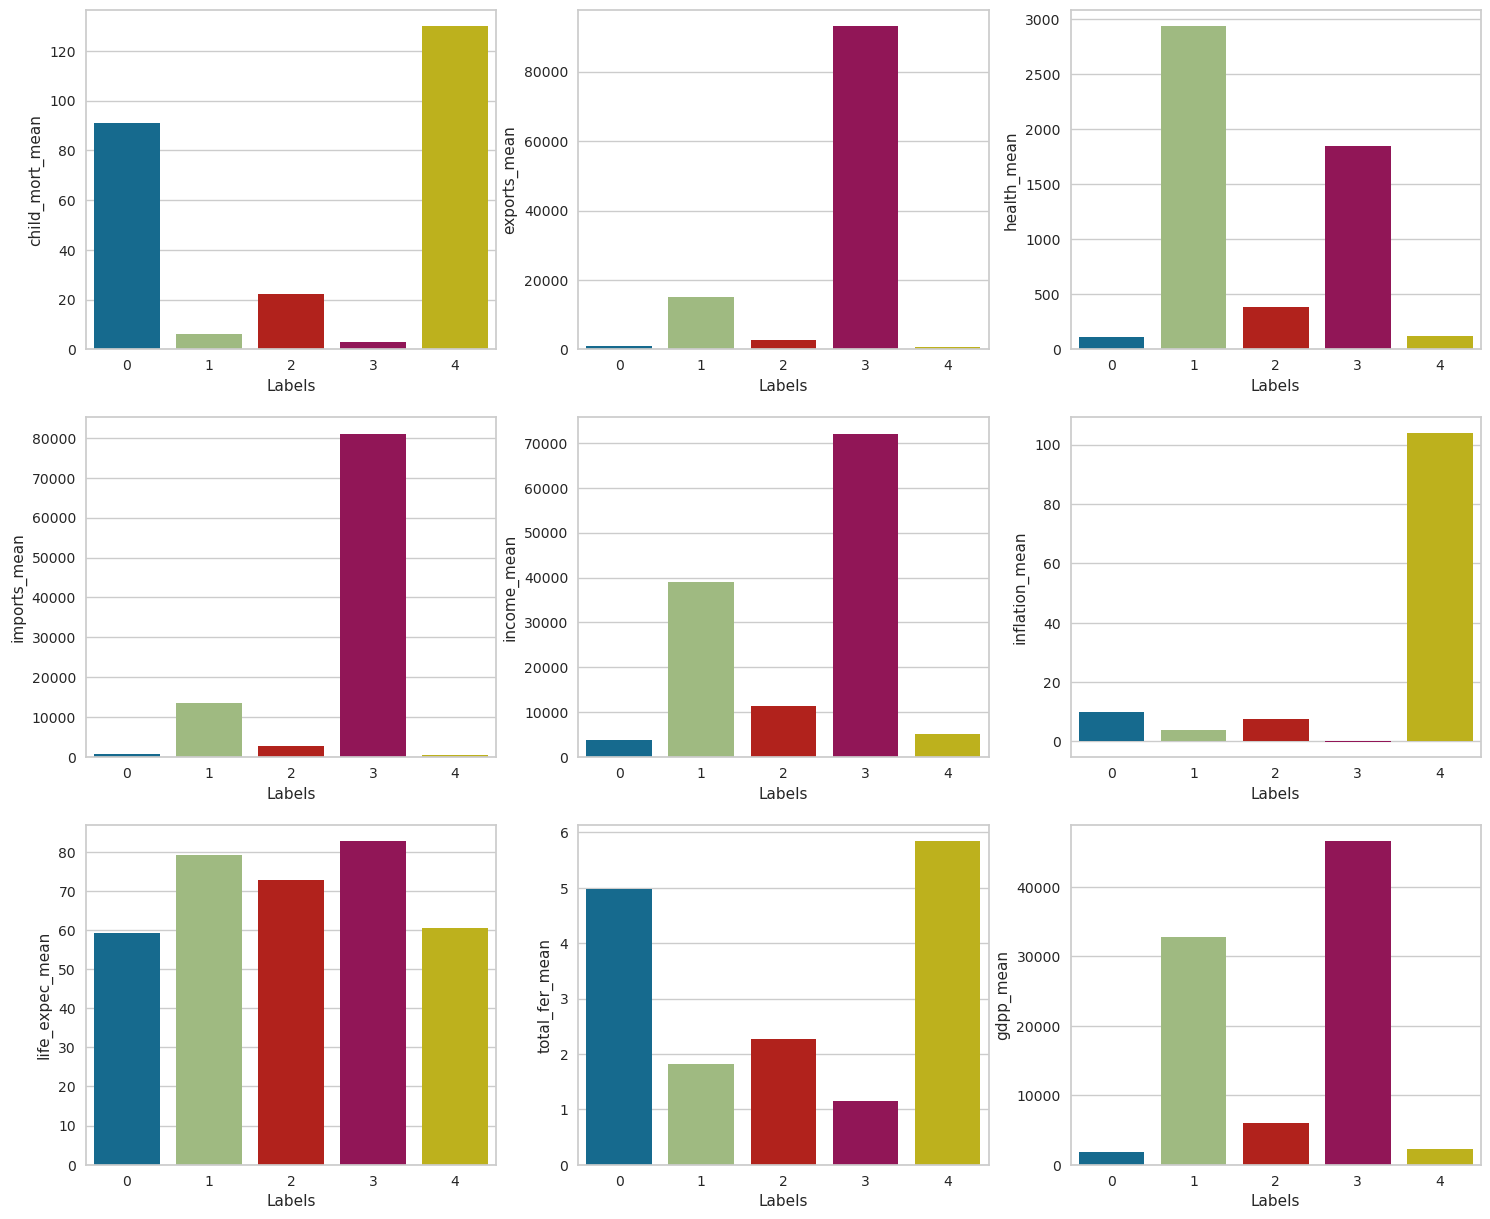

In [44]:
fig = plt.figure(figsize=(18,15))
for plot, feature in enumerate(cluster_analysis_df.columns[1:]):
    fig.add_subplot(3,3,plot+1)
    sns.barplot(x=cluster_analysis_df.Labels, y=cluster_analysis_df[feature])

**In cluster label 0 exports mean,health mean,imports mean,income mean,gdpp mean and also life expectation mean all are lower, so lets considered cluster 0 for aid distribution**

**We can conclude that the countries classified in Label 0 are in need of financial help.**

In [45]:
clustered_kmeans=countries_kmeans[countries_kmeans['Labels']==0]
Help_needed_country = clustered_kmeans.sort_values(['gdpp','income','child_mort','health','inflation','life_expec','total_fer','imports','exports']).head(10)

In [46]:
Help_needed_country

country  child_mort   exports   health  imports  income  \
26                    Burundi        93.6   20.6052  26.7960   90.552     764   
88                    Liberia        89.3   62.4570  38.5860  302.802     700   
37           Congo, Dem. Rep.       116.0  137.2740  26.4194  165.664     609   
112                     Niger       123.0   77.2560  17.9568  170.868     814   
132              Sierra Leone       160.0   67.0320  52.2690  137.655    1220   
93                 Madagascar        62.2  103.2500  15.5701  177.590    1390   
106                Mozambique       101.0  131.9850  21.8299  193.578     918   
31   Central African Republic       149.0   52.6280  17.7508  118.190     888   
94                     Malawi        90.5  104.6520  30.2481  160.191    1030   
50                    Eritrea        55.2   23.0878  12.8212  112.306    1420   

     inflation  life_expec  total_fer  gdpp  Labels  
26       12.30        57.7       6.26   231       0  
88        5.47        60.8       5.02   327       0  
37       20.80        57.5       6.54   334       0  
112       2.55        58.8       7.49   348       0  
132      17.20        55.0       5.20   399       0  
93        8.79        60.8       4.60   413       0  
106       7.64        54.5       5.56   419       0  
31        2.01        47.5       5.21   446       0  
94       12.10        53.1       5.31   459       0  
50       11.60        61.7       4.61   482       0

**These are the top 10 most help needed country**

In [47]:
k_country=[]
for i in Help_needed_country['country']:
    k_country.append(i)

# Using Hierarchical Clustering approach

In [48]:
countries_scaled.shape

(158, 9)

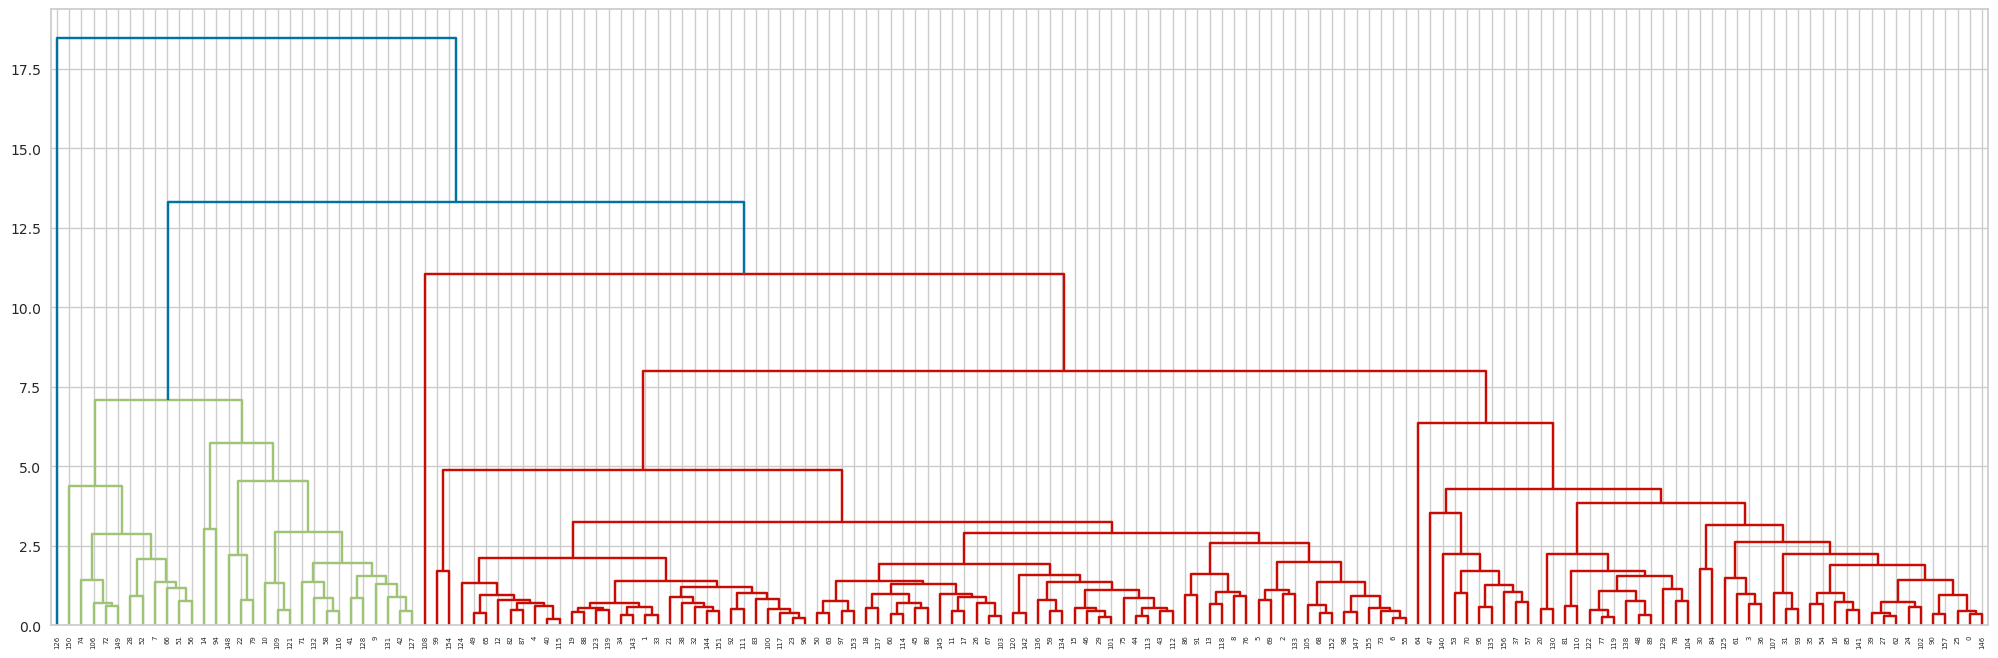

In [49]:
fig = plt.figure(figsize = (25, 8))
mergings = linkage(countries_scaled, method = "complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [50]:
h_cluster = cut_tree(mergings, n_clusters = 4).reshape(-1,)
h_cluster

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0])

In [51]:
h_df = new_df.copy()

In [52]:
h_df['Labels']=h_cluster
h_df['Labels'].value_counts()

0    127
1     29
2      1
3      1
Name: Labels, dtype: int64

In [53]:
h_df.head()

country  child_mort  exports    health   imports  income  \
0          Afghanistan        90.2    55.30   41.9174   248.297    1610   
1              Albania        16.6  1145.20  267.8950  1987.740    9930   
2              Algeria        27.3  1712.64  185.9820  1400.440   12900   
3               Angola       119.0  2199.19  100.6050  1514.370    5900   
4  Antigua and Barbuda        10.3  5551.00  735.6600  7185.800   19100   

   inflation  life_expec  total_fer   gdpp  Labels  
0       9.44        56.2       5.82    553       0  
1       4.49        76.3       1.65   4090       0  
2      16.10        76.5       2.89   4460       0  
3      22.40        60.1       6.16   3530       0  
4       1.44        76.8       2.13  12200       0

In [54]:
no_of_clusters = h_df.groupby(by='Labels')
child_mort_mean = no_of_clusters['child_mort'].mean()
exports_mean = no_of_clusters['exports'].mean()
health_mean = no_of_clusters['health'].mean()
imports_mean = no_of_clusters['imports'].mean()
income_mean = no_of_clusters['income'].mean()
inflation_mean = no_of_clusters['inflation'].mean()
life_expec_mean = no_of_clusters['life_expec'].mean()
total_fer_mean = no_of_clusters['total_fer'].mean()
gdpp_mean = no_of_clusters['gdpp'].mean()

In [55]:
h_cluster_analysis_df = pd.concat([pd.Series([0,1,2,3]),child_mort_mean,exports_mean,health_mean,imports_mean,income_mean,inflation_mean,life_expec_mean,
                                 total_fer_mean,gdpp_mean], axis=1)

In [56]:
h_cluster_analysis_df

0  child_mort       exports       health       imports        income  \
0  0   47.558268   1953.259508   285.526331   2069.379387   8663.094488   
1  1    6.148276  15076.862069  2941.186552  13582.134483  39024.137931   
2  2  130.000000    589.490000   118.131000    405.420000   5150.000000   
3  3    2.800000  93200.000000  1845.360000  81084.000000  72100.000000   

    inflation  life_expec  total_fer          gdpp  
0    8.401528   67.816535   3.272835   4458.929134  
1    3.750069   79.268966   1.823448  32796.551724  
2  104.000000   60.500000   5.840000   2330.000000  
3   -0.046000   82.700000   1.150000  46600.000000

In [57]:
h_cluster_analysis_df.columns = ["Labels","child_mort_mean","exports_mean","health_mean","imports_mean","income_mean","inflation_mean","life_expec_mean","total_fer_mean","gdpp_mean"]

In [58]:
h_cluster_analysis_df

Labels  child_mort_mean  exports_mean  health_mean  imports_mean  \
0       0        47.558268   1953.259508   285.526331   2069.379387   
1       1         6.148276  15076.862069  2941.186552  13582.134483   
2       2       130.000000    589.490000   118.131000    405.420000   
3       3         2.800000  93200.000000  1845.360000  81084.000000   

    income_mean  inflation_mean  life_expec_mean  total_fer_mean     gdpp_mean  
0   8663.094488        8.401528        67.816535        3.272835   4458.929134  
1  39024.137931        3.750069        79.268966        1.823448  32796.551724  
2   5150.000000      104.000000        60.500000        5.840000   2330.000000  
3  72100.000000       -0.046000        82.700000        1.150000  46600.000000

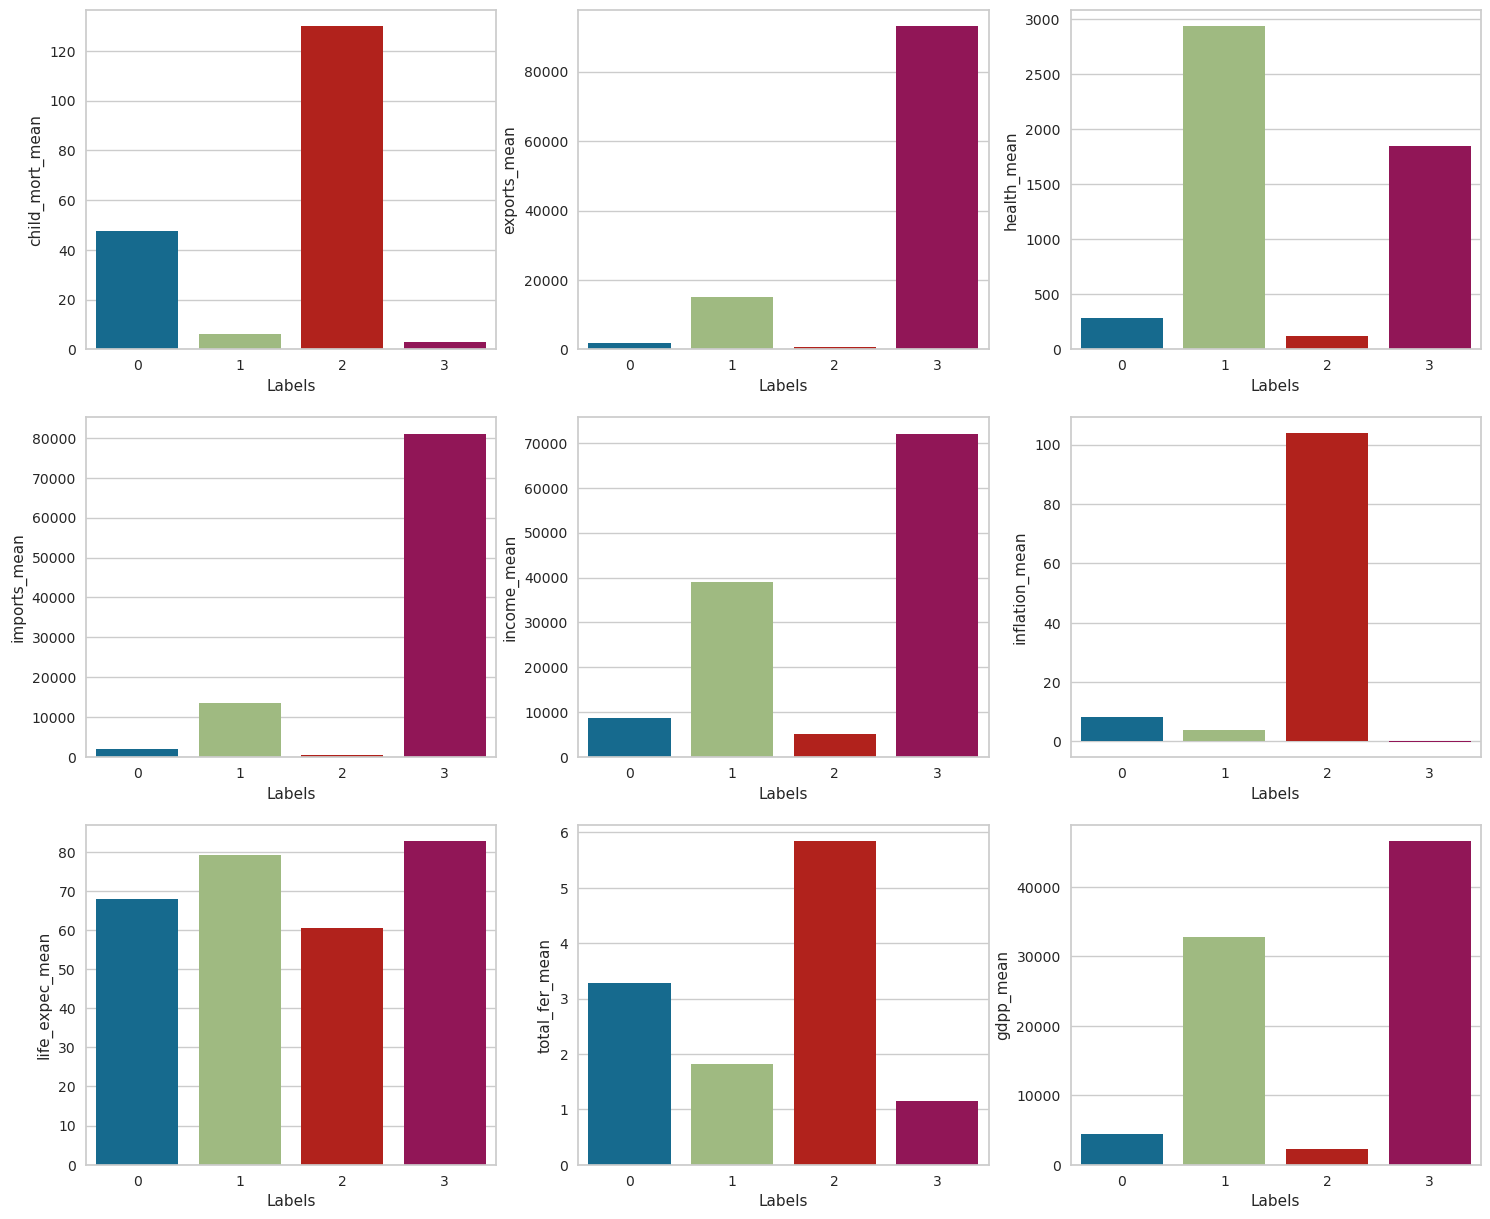

In [59]:
fig = plt.figure(figsize=(18,15))
for plot, feature in enumerate(h_cluster_analysis_df.columns[1:]):
    fig.add_subplot(3,3,plot+1)
    sns.barplot(x=h_cluster_analysis_df['Labels'], y=h_cluster_analysis_df[feature])

**In cluster number 2 there is only one country so let it for now, and by looking the barplot it is clear that health_mean,exports_mean,import_mean,income_mean and gdpp_mean of cluster label 0 is very low out of all clusters, thats why i am considering cluster 0 for aid distribution**

In [60]:
h_df=h_df[h_df['Labels']==0]
h_df = h_df.sort_values(['gdpp','income','child_mort','health','inflation','life_expec','total_fer','imports','exports']).head(10)

In [61]:
h_country=[]
for i in h_df['country']:
    h_country.append(i)

In [62]:
aid_nedded_country=pd.DataFrame({'K_mean':k_country,'Hierarchical':h_country})

**Here is the top 10 countries for financial assistance**

In [63]:
aid_nedded_country

K_mean              Hierarchical
0                   Burundi                   Burundi
1                   Liberia                   Liberia
2          Congo, Dem. Rep.          Congo, Dem. Rep.
3                     Niger                     Niger
4              Sierra Leone              Sierra Leone
5                Madagascar                Madagascar
6                Mozambique                Mozambique
7  Central African Republic  Central African Republic
8                    Malawi                    Malawi
9                   Eritrea                   Eritrea